### Risk Management Analysis: Introduction of Value at Risk (VaR)

#### Context:
A portfolio comprises three major holdings listed on the TSX index:

| Stocks             | # of Shares (Millions) | Price (January 31, 2022) | Value (in million CAD) | Weight |
|--------------------|------------------------|--------------------------|------------------------|--------|
| Bank of Montreal (BMO) | 10                     | CAD 143                  | CAD 1430               | 33.4%  |
| Suncor (SU)        | 15                     | CAD 29                   | CAD 435                | 10.2%  |
| Shopify (SHOP)     | 20                     | CAD 120.6                | CAD 2412               | 56.4%  |
| **Total Value**    |                        |                          | CAD 4277               | 100%   |

#### Objective:
Implementing Value at Risk (VaR) for this portfolio to evaluate its effectiveness before rolling it out across all bank investments.

#### Methodology:
Calculating the Value at Risk at a 99% confidence level over a 10-day period using two approaches:
1. **Historical Simulation**: Utilize past two years of market data.
2. **Monte Carlo Simulation**: Apply Geometric Brownian Motion (GBM) for overall portfolio volatility estimation, using data up to January 31, 2022. Volatility periods analyzed include one quarter and one year.


In [17]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Part a: Downloading data and calculating returns

def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def calculate_daily_returns(closing_prices):
    daily_returns = closing_prices.pct_change().dropna()
    return daily_returns

# getting the TSE data for the stocks
bmo_data = download_stock_data('BMO.TO', '2020-01-31', '2022-02-01')
su_data = download_stock_data('SU.TO', '2020-01-31', '2022-02-01')
shop_data = download_stock_data('SHOP.TO', '2020-01-31', '2022-02-01')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 1. Historical Simulation

We will calculate the historical 10-day VaR at the 99% confidence level for the portfolio using the historical simulation approach. This method involves using historical data to simulate the portfolio's returns over the 10-day period and then calculating the VaR based on the simulated returns.

In [18]:
# Calculate the daily returns for each stock

bmo_returns = calculate_daily_returns(bmo_data['Close'])
su_returns = calculate_daily_returns(su_data['Close'])
shop_returns = calculate_daily_returns(shop_data['Close'])

# Portfolio value as of January 31, 2022, with given numbers
portfolio_value = 10 * 143 + 15 * 29 + 20 * 120.6

# weights of each stock in the portfolio
weights = np.array([0.334, 0.102, 0.564])

# Calculate the portfolio returns
portfolio_returns = weights[0] * bmo_returns + weights[1] * su_returns + weights[2] * shop_returns

# Calculate the historical 1-day VaR at the 99% confidence level
historical_VaR = -np.percentile(portfolio_returns, 1, method='lower') * portfolio_value

# Calculate the historical 10-day VaR at the 99% confidence level
historical_10day_VaR = -np.percentile(portfolio_returns, 1, method='lower') * portfolio_value * np.sqrt(10)

# print("Historical 1-day VaR at the 99% confidence level:", round(historical_VaR, 2))
print("Historical 10-day VaR at the 99% confidence level:", round(historical_10day_VaR, 2))


Historical 10-day VaR at the 99% confidence level: 828.03


## 2. Monte Carlo Simulation


We will perform a Monte Carlo simulation to estimate the future portfolio value paths over a 10-day period. This simulation will involve generating random variates for each stock's daily returns and using them to calculate the portfolio's daily returns and value paths. We will then use the simulated portfolio values to estimate the 10-day VaR at the 99% confidence level.

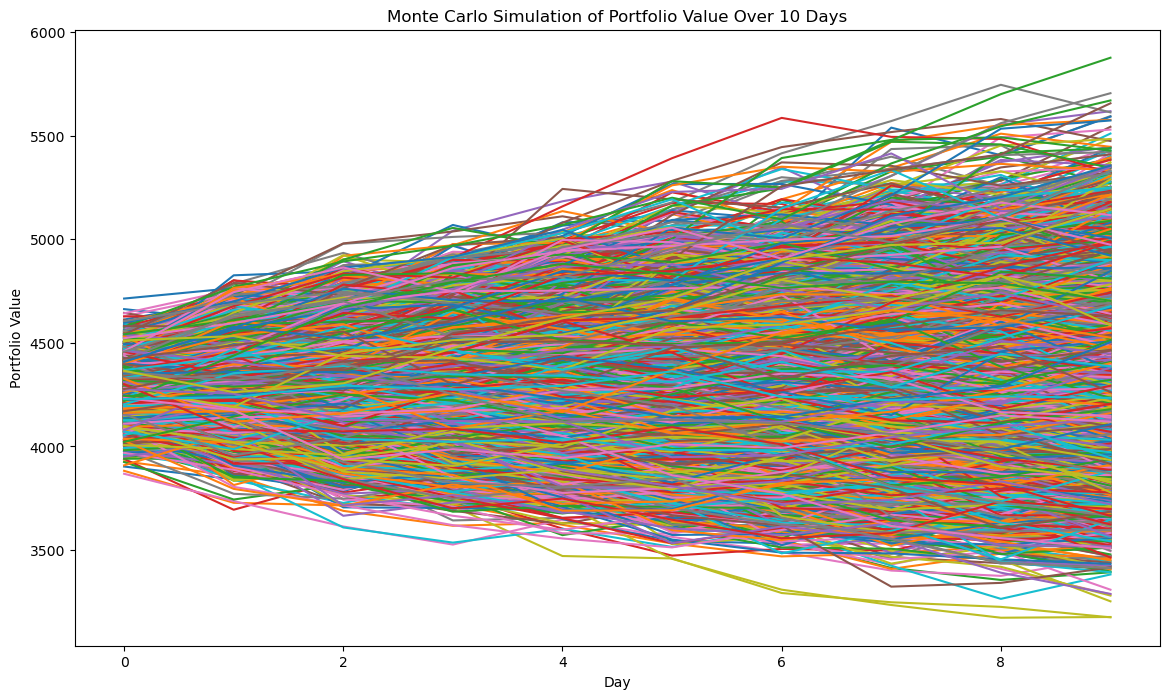

In [19]:
def monte_carlo_portfolio_simulation(daily_returns_df, weights, initial_portfolio_value, num_simulations, num_days):
    """
    Performs Monte Carlo simulations on a portfolio of stocks to estimate future portfolio value paths.

    Parameters:
    - daily_returns_df: DataFrame containing daily returns of the stocks in the portfolio.
    - weights: Array of portfolio weights for each stock.
    - initial_portfolio_value: The initial value of the portfolio.
    - num_simulations: The number of simulation paths to generate.
    - num_days: The number of days to simulate for each path.

    Returns:
    - simulation_results: A 2D array with shape (num_days, num_simulations), containing the simulated portfolio values.
    """
    # Ensure weights are a numpy array
    weights = np.array(weights)

    # Compute the mean returns and covariance matrix from the daily returns dataframe
    mean_returns = daily_returns_df.mean().values[:, np.newaxis]  # Convert to numpy array and add new axis for broadcasting
    cov_matrix = daily_returns_df.cov().values  # Convert to numpy array

    # Initialize an array to hold the simulation results
    simulation_results = np.zeros((num_days, num_simulations))

    # Precompute the Cholesky decomposition of the covariance matrix
    L = np.linalg.cholesky(cov_matrix)

    # Perform simulations
    for sim in range(num_simulations):
        # Generate random variates for each asset and day
        Z = np.random.normal(size=(len(weights), num_days))
        # Correlate the random variates
        R_tilde = L @ Z
        # Expand mean returns for broadcasting and calculate daily returns
        mean_returns_expanded = np.repeat(mean_returns, num_days, axis=1)
        daily_returns = weights @ (mean_returns_expanded + R_tilde)
        # Convert daily returns to portfolio value path and store the results
        portfolio_values = np.cumprod(1 + daily_returns) * initial_portfolio_value
        simulation_results[:, sim] = portfolio_values

    return simulation_results


# Daily Returns data all
daily_returns = pd.concat([bmo_returns, su_returns, shop_returns], axis=1)
daily_returns.columns = ['BMO', 'SU', 'SHOP']

num_simulations = 10000 # Number of simulations
num_days = 10 # Number of days for the simulation
weights = np.array([0.334, 0.102, 0.564]) # weight vector
initial_portfolio_value = 10 * 143 + 15 * 29 + 20 * 120.6 # initial portfolio value

simulation_results = monte_carlo_portfolio_simulation(daily_returns, weights, initial_portfolio_value, num_simulations, num_days)

plt.figure(figsize=(14, 8))
for sim in range(num_simulations):
    plt.plot(simulation_results[:, sim], label=f'Simulation {sim+1}')

plt.title('Monte Carlo Simulation of Portfolio Value Over 10 Days')
plt.xlabel('Day')
plt.ylabel('Portfolio Value')
plt.show()

In [20]:
# Calculate the Monte Carlo 10-day VaR at the 99% confidence level
VaR_10day = np.percentile(simulation_results[-1, :], 1)
VaR_10day = initial_portfolio_value - VaR_10day
print("Monte Carlo 10-day VaR at the 99% confidence level:", round(VaR_10day, 2))

Monte Carlo 10-day VaR at the 99% confidence level: 679.51
